In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import sys
import logging

import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
sys.path.append('..')
from src.models import get_model, SteganographyModels
from src.__main__ import CLI

print("Available models:")
print('\n'.join(list(map(lambda x: str(x).split('.')[-1], SteganographyModels))))

Available models:
LSB
BASE_MERGE
WT


## Constants

In [10]:
IMAGE_PATH = "../tests/test_images/cat.jpg"
#IMAGE_PATH = "../tests/test_messages/cs.png"

MODEL_NAME = "WT"

#MESSAGE = "Hello world !" * 100
MESSAGE = "../tests/test_images/casoar.jpeg"
MESSAGE = "../tests/test_messages/noisette.jpg"

## Show image and hide the image

In [11]:
cli = CLI()

INFO:CLI:Starting your request !


INFO:CLI:Loading image.


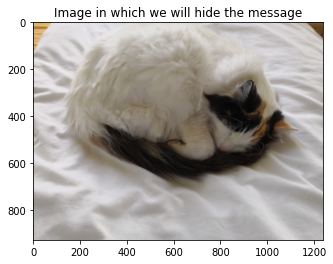

In [12]:
image = cli._load_image(IMAGE_PATH)
plt.figure()
plt.title("Image in which we will hide the message")
plt.imshow(image)
plt.show()

INFO:CLI:Loading message to hide.


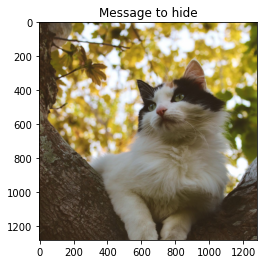

In [13]:
message = cli._load_message(MESSAGE)

if isinstance(message, str):
    print(message)
else:
    plt.figure()
    plt.title("Message to hide")
    plt.imshow(message)
    plt.show()

In [14]:
model = get_model(MODEL_NAME)

In [15]:
encoded_image = model.encode(
    image=image, message=message
)
print(encoded_image.shape)

(128, 128, 3)


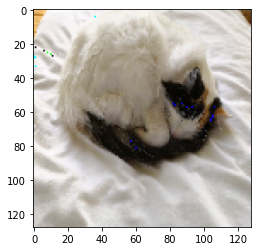

In [16]:
plt.figure()
plt.imshow(encoded_image)
plt.show()

(64,) (64, 64) (64, 64) (64, 64) (64, 64) (64, 64)
(64, 64) (64,) (64, 64)
(64,) (64, 64) (64, 64) (64, 64) (64, 64) (64, 64)
(64, 64) (64,) (64, 64)
(64,) (64, 64) (64, 64) (64, 64) (64, 64) (64, 64)
(64, 64) (64,) (64, 64)


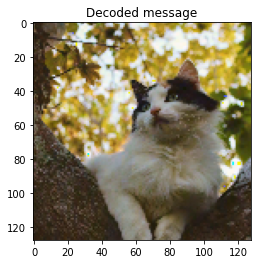

In [17]:
message = model.decode(encoded_image)
if isinstance(message, str):
    print('Decoded message:')
    print(message[:40])
    assert message == MESSAGE, "The messages are not the same"
else:
    plt.figure()
    plt.title("Decoded message")
    plt.imshow(message)
    plt.show()

## Data analysis

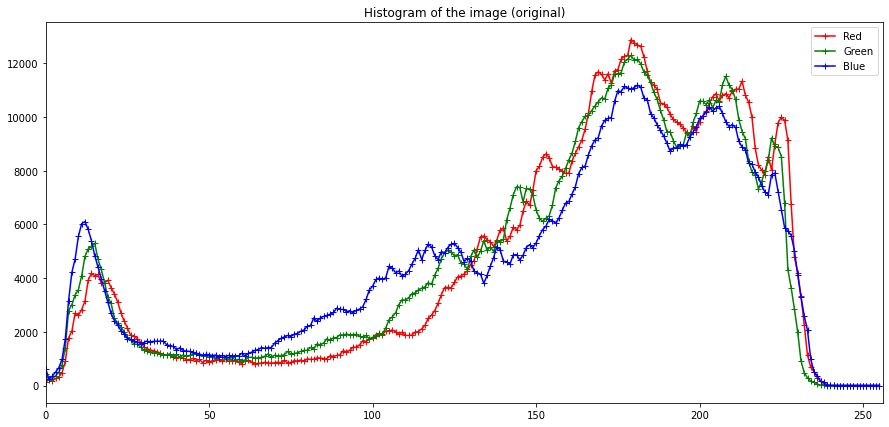

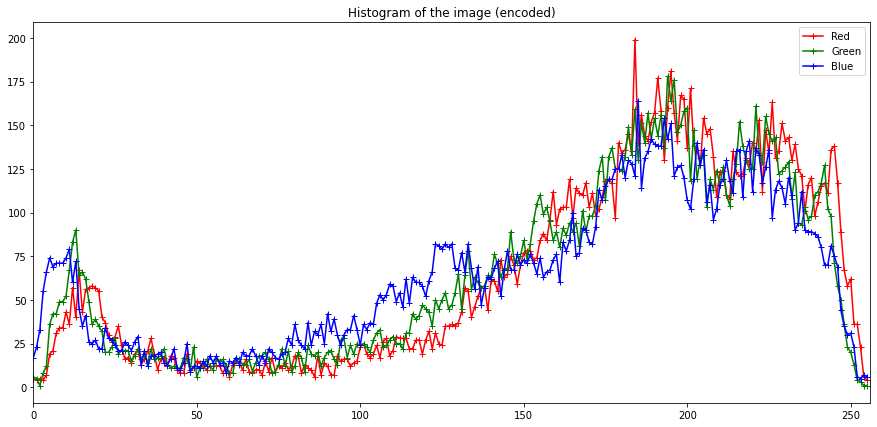

In [18]:
from src.analysis.histogram import generate_histogram, plot_histogram, compare_histograms, compute_diff_imgs

plt.figure(figsize=(15,7))
plt.title('Histogram of the image (original)')
plot_histogram(generate_histogram(image))
plt.figure(figsize=(15,7))
plt.title('Histogram of the image (encoded)')
plot_histogram(generate_histogram(encoded_image))

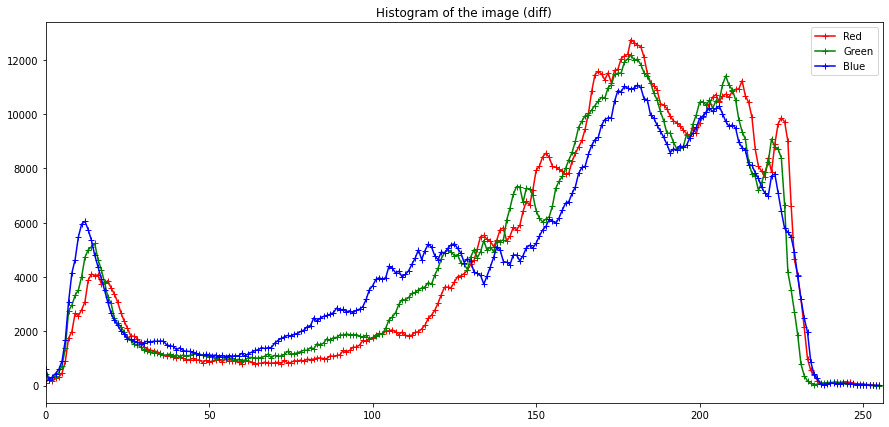

In [19]:
plt.figure(figsize=(15,7))
plt.title('Histogram of the image (diff)')

plot_histogram(
    compare_histograms(
        generate_histogram(image),
        generate_histogram(encoded_image)
    )
)

In [20]:
plt.imshow(compute_diff_imgs(image, encoded_image), cmap='gray');

AttributeError: 'bool' object has no attribute 'astype'